# Segmentation des clients d'un site e-commerce
*Auteur : Adeline Le Ray*
<hr>

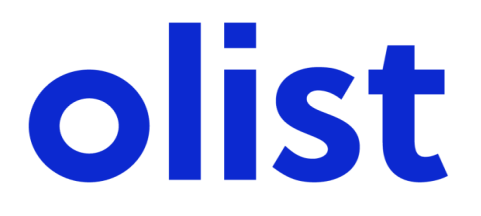

# <font color='#0a389f'>Introduction<a class="anchor" id="Presentation_projet"></a></font>
L'objectif de ce notebook est de déterminer la recommandation de fréquence à laquelle la segmentation doit être mise à jour pour rester pertinente, afin de pouvoir effectuer un devis de contrat de maintenance.


## <font color='#46abe6'>Sommaire</font>

<span style='background:#46abe6'><span style='color:white'>**Notebook 1 - Requêtes SQL**</span></span>

<span style='background:#46abe6'><span style='color:white'>**Notebook 2 - Analyse exploratoire**</span></span>

<span style='background:#46abe6'><span style='color:white'>**Notebook 3 - Essais clustering**</span></span>

<span style='background:#d5155b'><span style='color:white'>**Notebook 4 - Simulation maintenance**</span></span>

[Détermination de la fréquence de maintenance](#partie1)
* [Récupération des données](#1_1)
* [Evolution de l'Adjusted Rand Index](#1_2)
* [Evolution du nombre optimal de clusters](#1_3)
* [Evolution de la distribution des variables](#1_4)

[Simulation de la maintenance](#partie2)

[Conclusion & Perspectives](#conclusion)


## <font color='#46abe6'>Importation des librairies<a class="anchor" id="0_1"></a></font>

In [1]:
import sqlite3

import numpy as np
import pandas as pd
import math

from datetime import datetime
from dateutil.relativedelta import relativedelta 

from scipy.stats import ks_2samp

# graphiques
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import os

from IPython.display import Markdown # affichage Markdown des Outputs

from sklearn.preprocessing import StandardScaler

# K-Means
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer

from sklearn.metrics import adjusted_rand_score

In [2]:
# Version python
!python --version
# Version des librairies utilisées
print('\n'.join(f'{m.__name__} - {m.__version__}'
                for m in globals().values()
                if getattr(m, '__version__', None)))

Python 3.11.4
numpy - 1.26.4
pandas - 2.1.1
seaborn - 0.13.0


In [3]:
# Paramètres par défauts des graphiques
sns.set_style('whitegrid')        # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes
width = 7
height = 5
plt.figure(figsize=(width, height))
meanprops = {'marker':'o', 'markeredgecolor':'black','markerfacecolor':'firebrick'}

<Figure size 700x500 with 0 Axes>

In [4]:
# Options d'affichage : toutes les colonnes
pd.set_option('display.max_columns', None)

In [5]:
os.environ["OMP_NUM_THREADS"] = '1'

In [6]:
# Définition de la palette de couleur
my_palette =  px.colors.qualitative.Plotly

In [7]:
df_cleaned = pd.read_pickle('df_cleaned.pkl')
df_cleaned.set_index(df_cleaned.columns[0], inplace=True)

## <font color='#46abe6'>Définition des fonctions<a class="anchor" id="0_2"></a></font>

In [8]:
def generate_query_rfms(initial_start_date, end_date):
    query = f"""
        --- Date de la dernière commande
        WITH LastOrderDate AS (
            SELECT MAX(order_purchase_timestamp) AS last_order_date 
            FROM orders
            WHERE order_purchase_timestamp < DATE('{end_date.strftime("%Y-%m-%d")}')
        ),
        
        --- Montant de chaque commande
        total_payment AS (
            SELECT p.order_id, SUM(p.payment_value) AS total_payment
            FROM order_pymts p
            GROUP BY p.order_id
        ),
        
        --- Date de la dernière revue par commande        
        LastReview AS (
            SELECT order_id, MAX(review_answer_timestamp) AS max_timestamp
            FROM order_reviews
            GROUP BY order_id
        ),
        
        --- Nombre d'items par produit et par commande        
        nb_items AS (
        SELECT 
            oi.order_id,
            COUNT(oi.order_item_id) AS nb_items, 
            COUNT(DISTINCT oi.product_id) AS nb_products,
            oi.product_id,
            t.product_category_name_english
                        
        FROM order_items oi
        
        LEFT JOIN products p ON oi.product_id = p.product_id
        LEFT JOIN translation t ON p.product_category_name = t.product_category_name
        LEFT JOIN orders o ON o.order_id = oi.order_id
        LEFT JOIN customers c ON o.customer_id = c.customer_id
        
        GROUP BY oi.order_id
        
        --- Filtre sur les catégories de produit et les commandes d'un seul type de produit         
        HAVING 
            nb_products = 1 
            AND product_category_name_english IN ('computers_accessories', 'auto', 'watches_gifts', 'telephony')
        )

        --- Variables Recency, Frequency et monetary   
        SELECT  c.customer_unique_id,
                ROUND(JULIANDAY((SELECT last_order_date FROM LastOrderDate)) - JULIANDAY(MAX(o.order_purchase_timestamp))) AS recency,
                COUNT(DISTINCT o.order_id) AS frequency,
                SUM(t.total_payment) AS monetary,
                AVG(r.review_score) AS avg_review_score

        FROM orders o

        LEFT JOIN customers c ON o.customer_id = c.customer_id
        LEFT JOIN total_payment t on o.order_id = t.order_id
        LEFT JOIN order_reviews r ON o.order_id = r.order_id
        LEFT JOIN LastReview l ON r.order_id = l.order_id AND r.review_answer_timestamp = l.max_timestamp
        
        WHERE 
            o.order_purchase_timestamp > DATE('{initial_start_date.strftime("%Y-%m-%d")}')
            AND o.order_purchase_timestamp < DATE('{end_date.strftime("%Y-%m-%d")}')
            AND o.order_status = 'delivered'
            AND c.customer_unique_id NOT IN (
                            SELECT c.customer_unique_id
                            FROM orders o

                            INNER JOIN nb_items i ON o.order_id = i.order_id
                            INNER JOIN order_items oi ON i.order_id = oi.order_id
                            INNER JOIN customers c ON o.customer_id = c.customer_id

                            GROUP BY c.customer_unique_id, i.product_category_name_english
                            
                            HAVING 
                                COUNT(DISTINCT i.product_id) = 1 
                                AND COALESCE(SUM(i.nb_items), 0) >100
                            ) --- Exclure les B2B   
        
        GROUP BY c.customer_unique_id

    """
    return query

In [9]:
def extract_data_rfms(initial_start_date, final_date, train_size, increment, granulometry):
    """!
    @brief Extrait les données de la base de données entre les dates spécifiées.

    Cette fonction extrait les données de la base de données entre les dates spécifiées, en segmentant la période en intervalles définis par l'incrément initial et la fréquence de maintenance.

    @param initial_start_date: Date de début initiale de l'extraction (type datetime).
    @param final_date: Date de fin de l'extraction (type datetime).
    @param train_size: Incrément initial en mois pour le premier intervalle de temps (type integer).
    @param increment: Fréquence de maintenance en semaines pour les intervalles de temps suivants (type integer).
    @param granulometry : Unité de l'incrément, mois ou semaines : valeurs 'months' or 'weeks' (type string).

    @return dfs: Liste des DataFrames contenant les données extraites pour chaque intervalle de temps (type list).
    @return dates: Liste des dates de fin de chaque intervalle de temps (type list).
    """
    # Initialisation des variables et liste
    start_date = initial_start_date
    i = 0
    dfs = []
    dates = []

    while start_date < final_date:  # Condition pour arrêter la boucle
        # Définir la date de fin en ajoutant l'incrément
        if i == 0:
            end_date = start_date + relativedelta(months=train_size)
        else:
            if granulometry == 'months':
                end_date = start_date + relativedelta(months=increment)
            else:
                end_date = start_date + relativedelta(weeks=increment)

        # Requête SQL pour récupérer les données entre start_date et end_date
        query = generate_query_rfms(initial_start_date, end_date)

        # Exécuter la requête SQL et stocker le résultat dans un DataFrame
        df = pd.read_sql_query(query, conn)
        
        # Définition des classes
        df['avg_review_score'].fillna(0, inplace=True)
        df.loc[(df['avg_review_score']<4)&(df['avg_review_score']>0), 'avg_review_score'] = -1
        df.loc[df['avg_review_score']>=4, 'avg_review_score'] = 1
        df.rename(columns={'avg_review_score':'review_score_class'}, inplace=True)
        
        # Index = colonne 'customer_unique_id'
        df.set_index(df.columns[0], inplace=True)

        # Ajouter le DataFrame à la liste
        dfs.append(df)

        # Incrémenter i et la date de début
        i += 1
        start_date = end_date

        # Ajouter la date de fin à la liste
        dates.append(end_date.strftime('%Y-%m-%d'))
        
    return dfs, dates

In [10]:
def elbow_value(df, k_min, k_max):
    """!
    @brief Détermine le nombre optimal de clusters

    Cette fonction permet de déterminer le nombre optimal de clusters avec la méthode du coude pour la metric distorsion.

    @param df: le DataFrame contenant les données (type pd.DataFrame).
    @param k_min: Nombre minimum de clusters à tester (type integer).
    @param k_max: Nombre maximum de clusters à tester (type integer).
    @param random_state: Seed pour la reproductibilité des résultats (par défaut : 42) (type integer).

    @return k: Nombre optimal de clusters (type integer).
    """    
    # Centrage et réduction des variables
    X = df.values
    scaler = StandardScaler()  # Instanciation du scaler
    X_scaled = scaler.fit_transform(X)  # Données scalées
    
    # Nombre de clusters optimum
    km = KMeans(n_init=10, init='k-means++')
    visualizer = KElbowVisualizer(km, k=(k_min, k_max))
    visualizer.fit(X_scaled)
    visualizer.show()
    
    k = visualizer.elbow_value_
    
    return k

In [11]:
def ari_calculation(dfs, k):
    """!
    @brief Calcule l'Adjusted Rand Index pour un ensemble de données

    Cette fonction permet de :
    - déterminer le nombre optimum de clusters pour le jeu d'entraînement (premier élément de la liste de dataframes dfs)
    - entraîner un objet k-means avec ce jeu d'entraînement
    - prédire les clusters pour chaque jeu de données suivant avec le k-means entraîné pour déterminer labels_pred
    - entraîner un objet k-means pour chaque jeu de données suivant pour déterminer labels_true
    - calcule l'adjusted rand score pour chaque jeu de données

    @param dfs: Liste de DataFrames contenant les données à clusteriser.
    @param k: Nombre de clusters

    @return ARI: Liste contenant les adjusted_rand_score pour chaque DataFrame.
    """
    # Initialisation des listes de stockage
    labels_pred = []
    labels_true = []
    ARI = []

    # Boucle sur les dataframes
    for i in range(0, len(dfs)):
        df = dfs[i]
        X = df.values  # Matrice des données
        
        # Cas de l'entraînement initial
        if i == 0:    
            
            # Centrage et réduction des variables
            scaler_pred = StandardScaler()  # Instanciation du scaler
            X_scaled_pred = scaler_pred.fit_transform(X)  # Données scalées
            
            # Entraînement du kmeans_pred
            kmeans_pred = KMeans(n_clusters=k, n_init=10, init='k-means++')
            kmeans_pred.fit(X_scaled_pred)
            
            # Stockage des clusters dans les listes labels_pred et labels_true            
            labels_pred.append(kmeans_pred.labels_)
            labels_true.append(kmeans_pred.labels_)
            

        else:
            # Predict labels
            # Centrage et réduction des variables avec le scaler entraîné
            X_scaled_pred = scaler_pred.transform(X)  # Données scalées

            # Stockage des clusters de la prédiction k_means_pred dans la liste labels_pred
            labels_pred.append(kmeans_pred.predict(X_scaled_pred))

            # True labels
            # Centrage et réduction des variables
            scaler_true = StandardScaler()  # Instanciation du scaler
            X_scaled_true = scaler_true.fit_transform(X)  # Données scalées
            
            # Instanciation et Entraînement du modèle k-means sur l'ensemble du jeu de données
            kmeans_true = KMeans(n_clusters=k, n_init=10, init='k-means++')
            kmeans_true.fit(X_scaled_true)

            # Stockage des clusters dans la liste labels_true
            labels_true.append(kmeans_true.labels_)
            
         # Calcul de l'ARI et stockage dans la liste ARI
        ARI.append(adjusted_rand_score(labels_true[i], labels_pred[i]))

    return ARI

In [12]:
def plot_ARI(dfs, dates, k):
    """!
    @brief Affiche le graphique d'évolution de l'ARI

    Cette fonction permet de calculer l'adjusted rand score pour plusieurs jeux de données en utilisant la 
    fonction ari_calculation, puis affiche l'évolution de l'ARI.

    @param dfs: Liste de DataFrames contenant les données à clusteriser.
    @param dates : Dates à prendre en compte la série temporelle (list)
    @param k: Nombre de clusters (integer)
    """
    # Calcul de ARI
    ARI = ari_calculation(dfs, k)
    
    # Représentation graphique de l'ARI
    sns.lineplot(x=dates, y=ARI, label='Adjusted Rand Index (ARI)')
    plt.axhline(y=0.8, color='r', linestyle='--')# limite pour maintenance
    plt.title("Evolution de l'Adjusted Rand Index (ARI)")
    plt.xlabel('Dates')
    plt.ylabel('Adjusted Rand Index (ARI)')
    plt.xticks(range(len(dates)), labels=dates, rotation=45)  

    plt.show()

In [13]:
def plot_simu(dfs, dates, k, freq):
    """!
    @brief Affiche le graphique d'évolution de l'ARI pour la simulation de maintenance

    Cette fonction permet de calculer l'adjusted rand score pour plusieurs jeux de données et de simuler une mainetance
    en utilisant la fonction maintenance_simulation,  puis affiche l'évolution de l'ARI.

    @param dfs: Liste de DataFrames contenant les données à clusteriser.
    @param dates : Dates à prendre en compte la série temporelle (list)
    @param k: Nombre de clusters (integer)
    @param freq: Fréquence de maintenance en mois (integer)    
    """
    # Calcul de ARI
    ARI = maintenance_simulation(dfs, k, freq)
    
    # Représentation graphique de l'ARI
    sns.lineplot(x=dates, y=ARI, label='Adjusted Rand Index (ARI)')
    plt.axhline(y=0.8, color='r', linestyle='--') # limite
    plt.title(f"Evolution de l'Adjusted Rand Index (ARI) avec fréquence de maintenance = {freq} mois")
    plt.xlabel('Dates')
    plt.ylabel('Adjusted Rand Index (ARI)')
    plt.xticks(range(len(dates)), labels=dates, rotation=45)  

    plt.show()

In [14]:
def maintenance_simulation(dfs, k, freq):
    """!
    @brief Calcule l'Adjusted Rand Index pour un ensemble de données

    Cette fonction permet de :
    - déterminer le nombre optimum de clusters pour le jeu d'entraînement (premier élément de la liste de dataframes dfs)
    - entraîner un objet k-means avec ce jeu d'entraînement
    - prédire les clusters pour chaque jeu de données suivant avec le k-means entraîné pour déterminer labels_pred
    - entraîner un objet k-means pour chaque jeu de données suivant pour déterminer labels_true
    - calcule l'adjusted rand score pour chaque jeu de données

    @param dfs: Liste de DataFrames contenant les données à clusteriser.
    @param k: Nombre de clusters

    @return ARI: Liste contenant les adjusted_rand_score pour chaque DataFrame.
    """
    # Initialisation des listes de stockage
    labels_pred = []
    labels_true = []
    ARI = []

    # Boucle sur les dataframes
    for i in range(0, len(dfs)):
        df = dfs[i]
        X = df.values  # Matrice des données
        
        # Ré-entraînement à la fréquence définie
        if i%freq == 0:    
            
            # Centrage et réduction des variables
            scaler_pred = StandardScaler()  # Instanciation du scaler
            X_scaled_pred = scaler_pred.fit_transform(X)  # Données scalées
            
            # Entraînement du kmeans_pred
            kmeans_pred = KMeans(n_clusters=k, n_init=10, init='k-means++')
            kmeans_pred.fit(X_scaled_pred)
            
            # Stockage des clusters dans les listes labels_pred et labels_true            
            labels_pred.append(kmeans_pred.labels_)
            labels_true.append(kmeans_pred.labels_)
            

        else:
            # Predict labels
            # Centrage et réduction des variables avec le scaler entraîné
            X_scaled_pred = scaler_pred.transform(X)  # Données scalées

            # Stockage des clusters de la prédiction k_means_pred dans la liste labels_pred
            labels_pred.append(kmeans_pred.predict(X_scaled_pred))

            # True labels
            # Centrage et réduction des variables
            scaler_true = StandardScaler()  # Instanciation du scaler
            X_scaled_true = scaler_true.fit_transform(X)  # Données scalées
            
            # Instanciation et Entraînement du modèle k-means sur l'ensemble du jeu de données
            kmeans_true = KMeans(n_clusters=k, n_init=10, init='k-means++')
            kmeans_true.fit(X_scaled_true)

            # Stockage des clusters dans la liste labels_true
            labels_true.append(kmeans_true.labels_)
            
         # Calcul de l'ARI et stockage dans la liste ARI
        ARI.append(adjusted_rand_score(labels_true[i], labels_pred[i]))

    return ARI

# <font color='#0a389f'>Détermination de la fréquence de maintenance<a class="anchor" id="partie1"></a></font>

In [15]:
# Connexion à la base de données SQLite
conn = sqlite3.connect('olist.db')

# Date de début et fin
initial_date = datetime(2017, 1, 1)
final_date = datetime(2018, 9, 1)

## <font color='#46abe6'>Récupération des données<a class="anchor" id="1_1"></a></font>

In [16]:
# définition des paramètres train_size et increment
train_size = 6 # période d'échantillonnage pour le jeu d'entraînement en mois
increment = 1 # incrément mois

In [17]:
dfs_rfms, dates = extract_data_rfms(initial_date, final_date, train_size, increment, 'months')

## <font color='#46abe6'>Evolution de l'Adjusted Rand Index<a class="anchor" id="1_2"></a></font>

Pour déterminer la fréquence de maintenance, nous utiliserons l'ARI score. Le seuil de déclenchement d'une maintenance est défini à ARI <0.8.

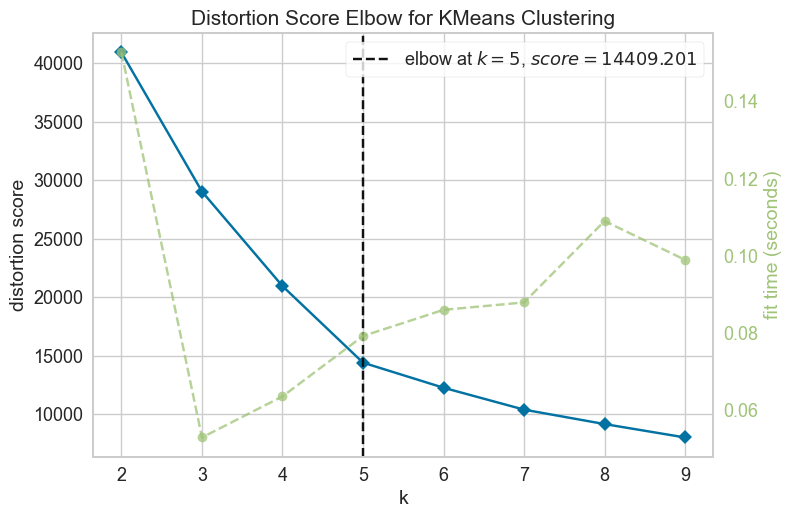

In [18]:
# valeur k nombre de clusters optimal
k = elbow_value(dfs_rfms[0], k_min=2, k_max=10)

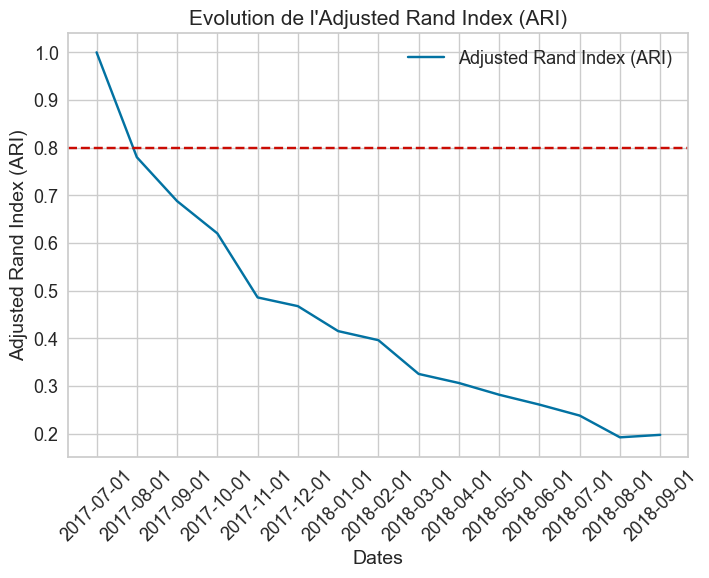

In [19]:
# Calcul des ARI et représentation de l'évolution dans le temps
plot_ARI(dfs_rfms, dates, k)

La première maintenance devra avoir lieu au bout de 2 mois.

## <font color='#46abe6'>Evolution du nombre optimal de clusters<a class="anchor" id="1_3"></a></font>

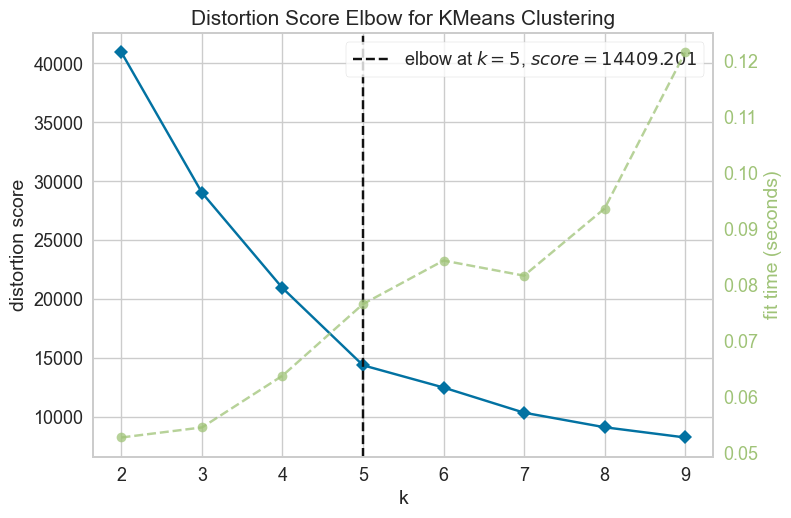

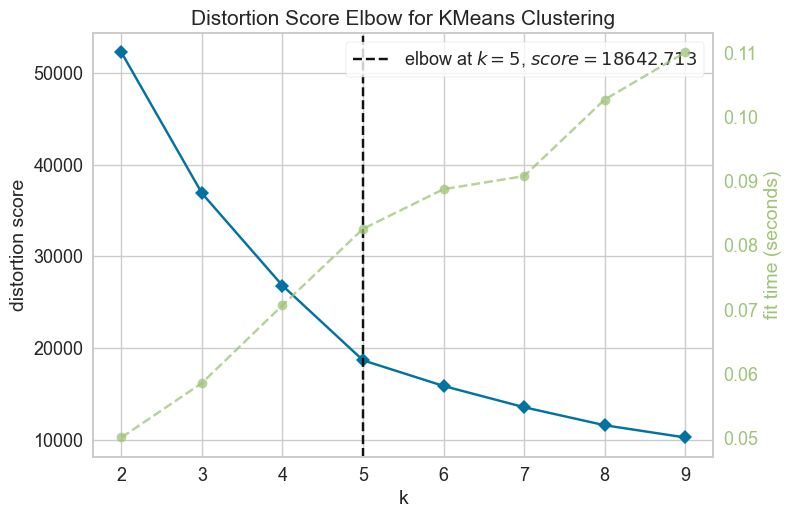

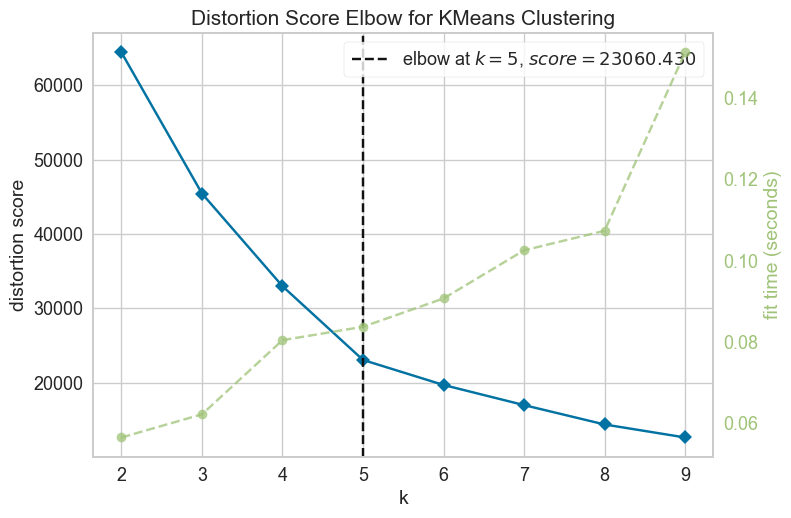

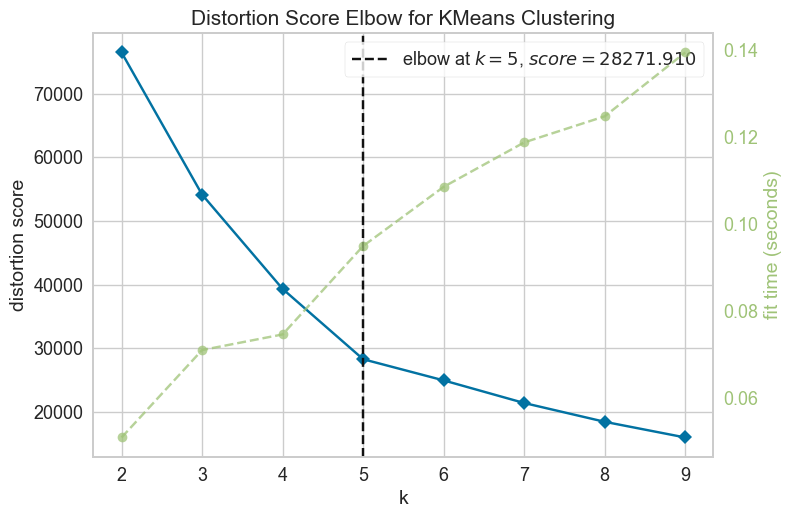

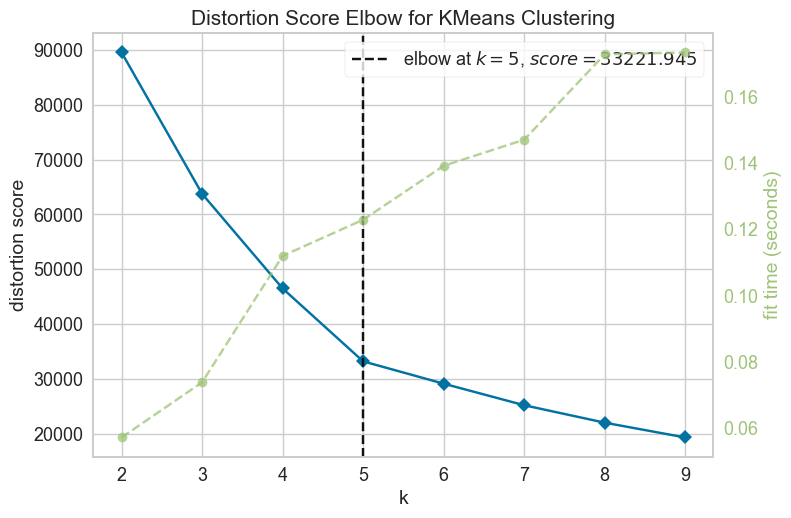

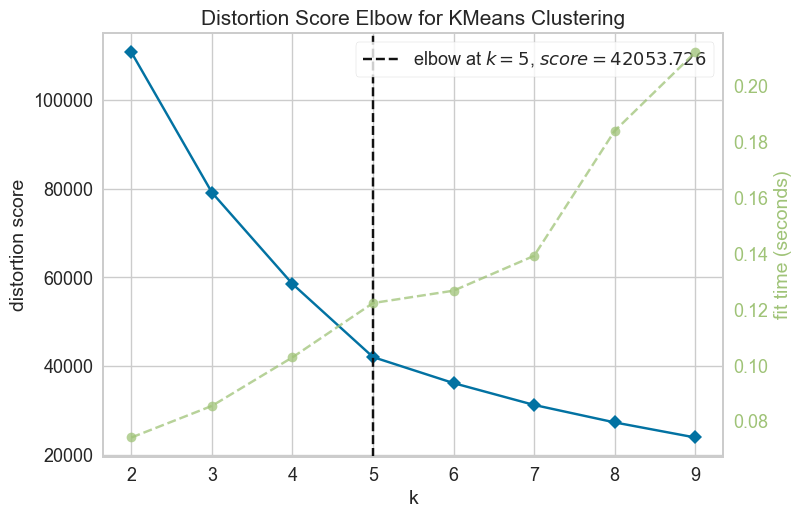

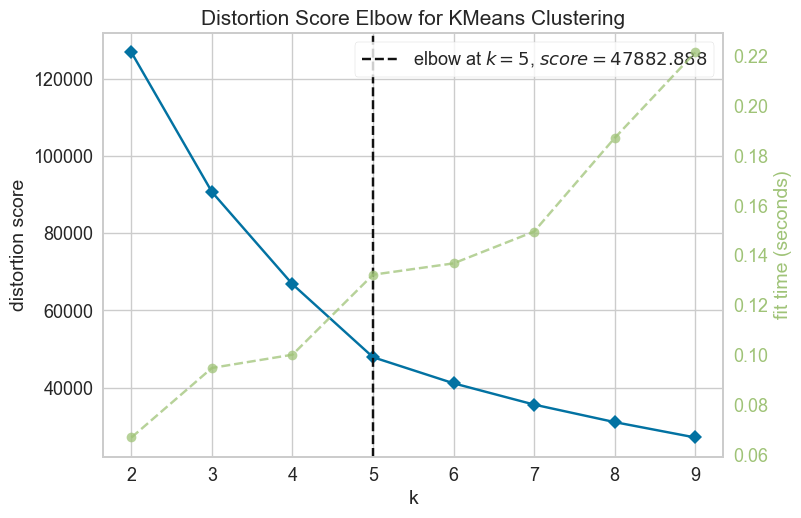

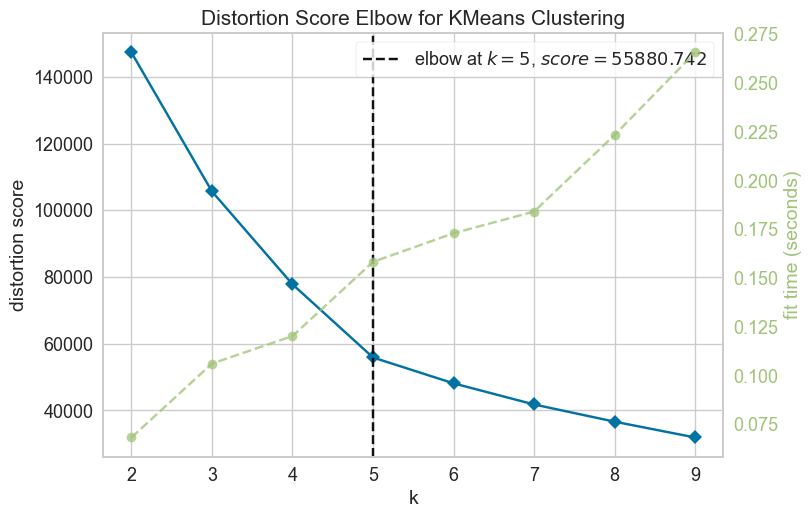

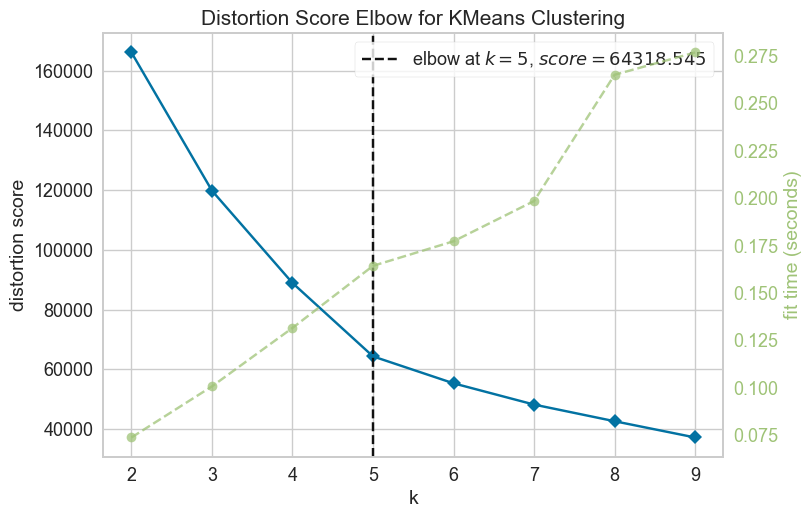

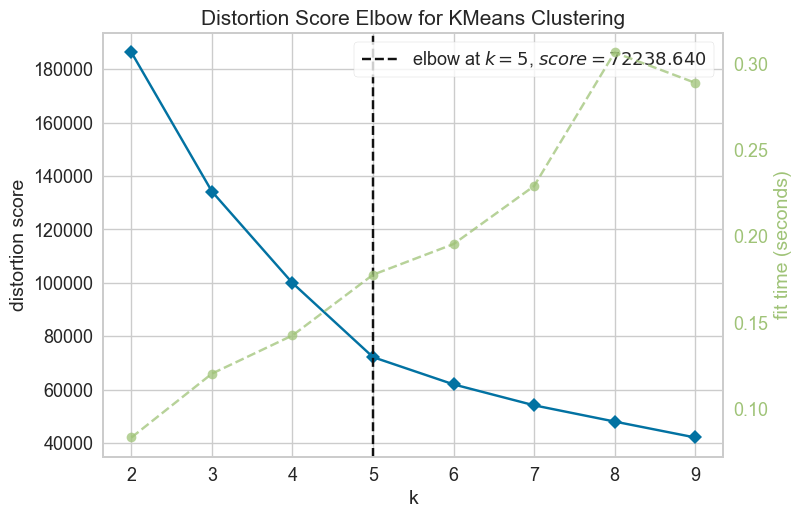

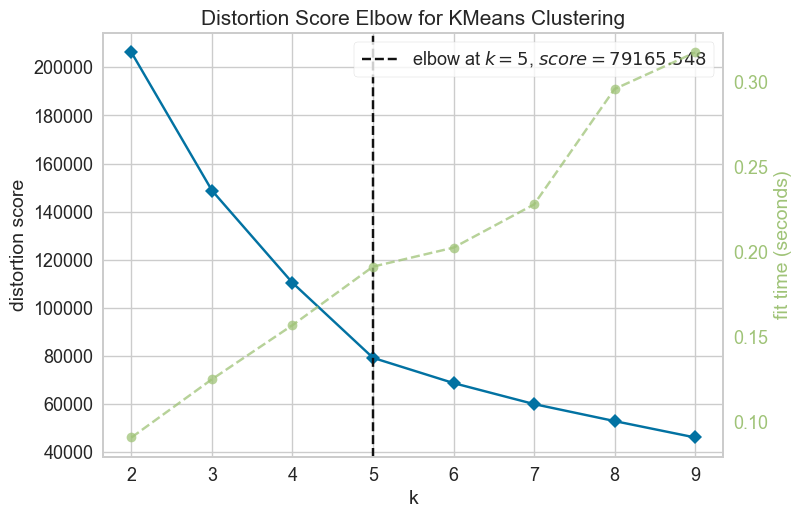

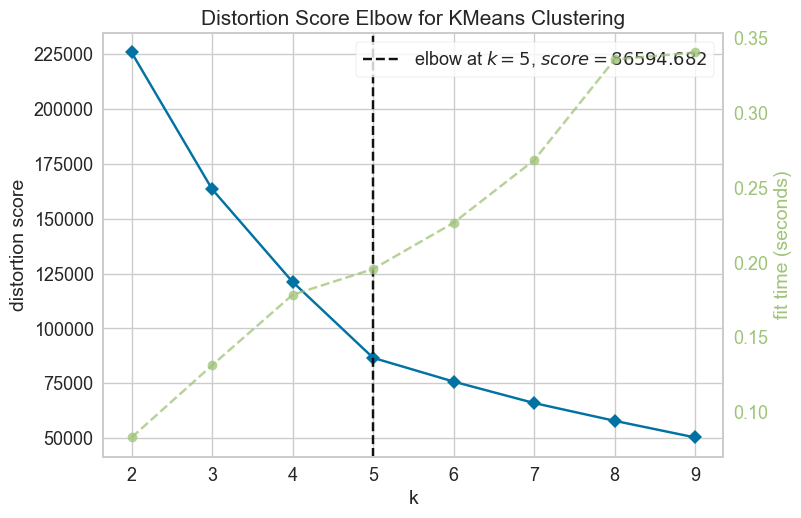

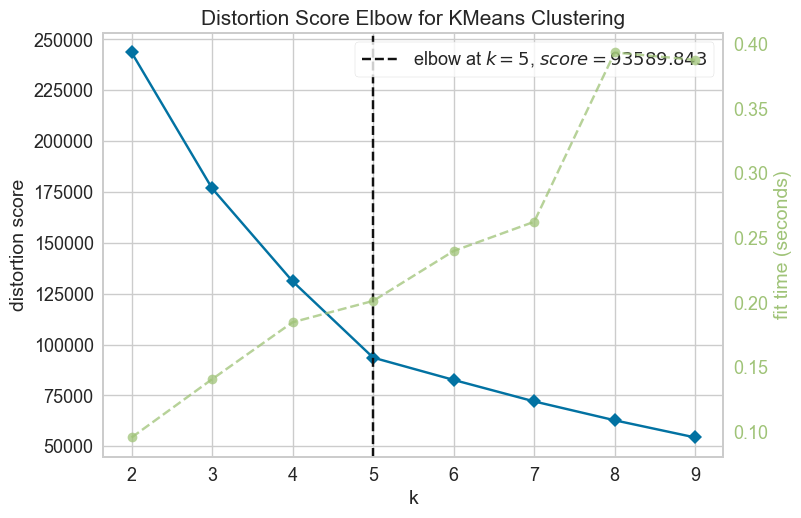

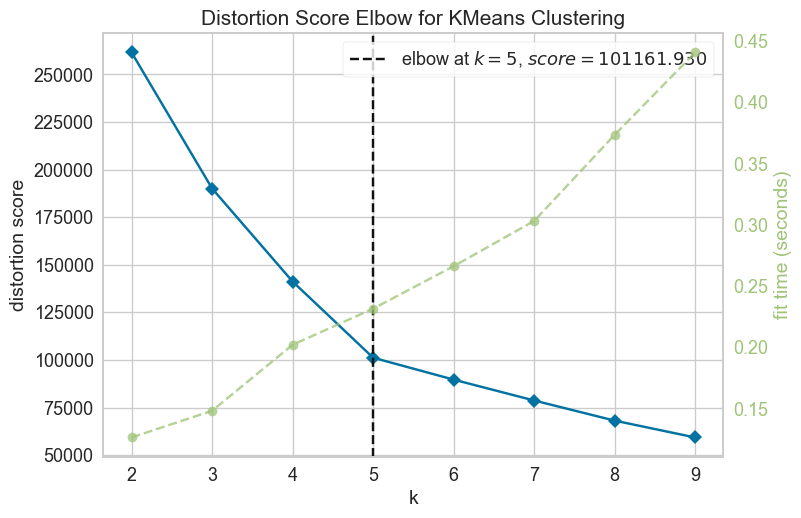

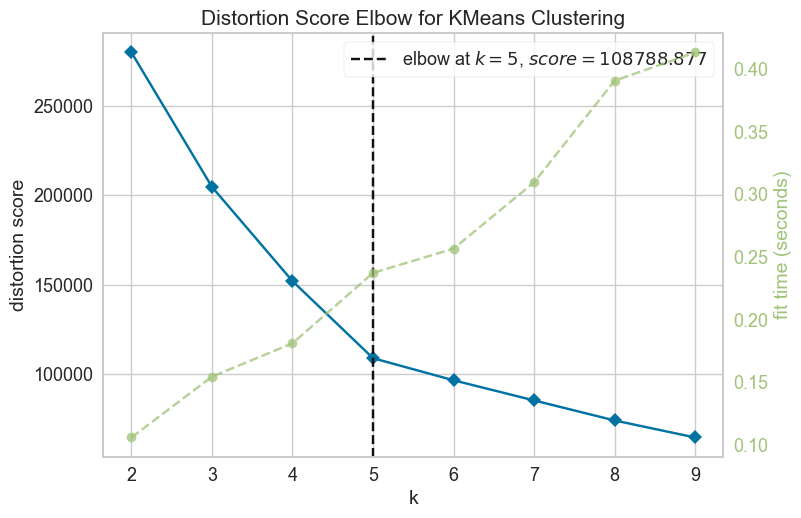

In [20]:
k_list = []

for df in dfs_rfms:
    k = elbow_value(df, k_min=2, k_max=10)
    k_list.append(k)

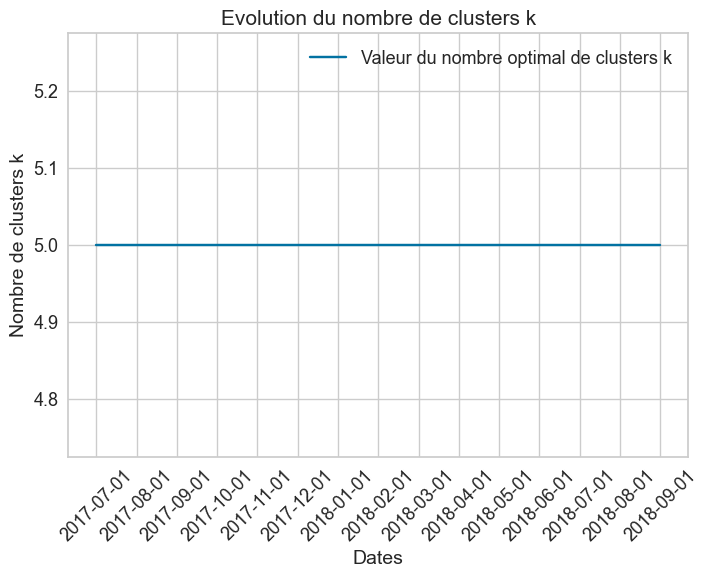

In [21]:
# Plot des valeurs du coude
sns.lineplot(x=dates, y=k_list, label='Valeur du nombre optimal de clusters k')
plt.ylabel('Nombre de clusters k')
plt.title('Evolution du nombre de clusters k')
plt.xlabel('Dates')
plt.xticks(range(len(dates)), labels=dates, rotation=45)
plt.show()

Dans le cas présent le nombre de clusters reste le même. 

## <font color='#46abe6'>Evolution de la distribution des variables<a class="anchor" id="1_4"></a></font>

In [22]:
# Ajouter une colonne 'Date' au df
dfs_dates = []

for df, date in zip(dfs_rfms, dates):
    df_date = df.copy()
    df_date['date'] = date
    dfs_dates.append(df_date)
    
# Concaténer tous les DataFrames en un seul 
df_merged = pd.concat(dfs_dates)

# Convertir la colonne 'Date' en type datetime
df_merged['date'] = pd.to_datetime(df_merged['date'])

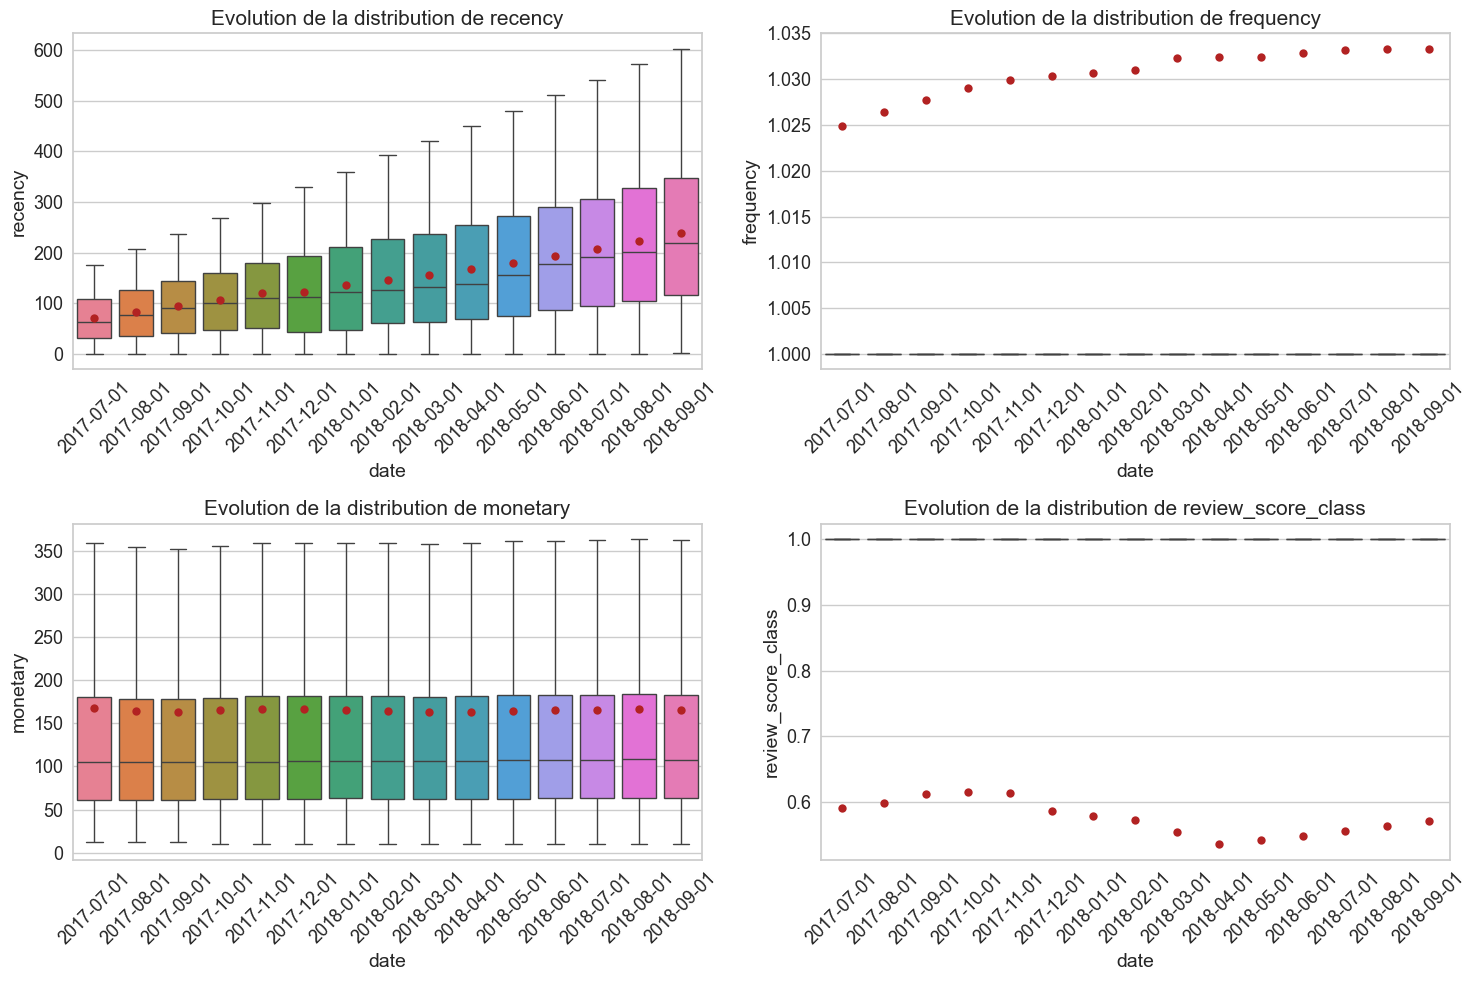

In [23]:
# Evolution de la distribution des variables
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), tight_layout=True)

for i, column in enumerate(df_merged.columns):
    if column != 'date':  # toutes les colonnes sauf dates
        axs = ax[i//2, i%2]
        sns.boxplot(data=df_merged, 
                    x='date', 
                    y=column,
                    hue='date',
                    ax=axs,
                    showmeans=True,
                    showfliers=False,
                    meanprops=meanprops)
        axs.set_title(f'Evolution de la distribution de {column}')
        axs.tick_params(axis='x', rotation=45)

plt.show()

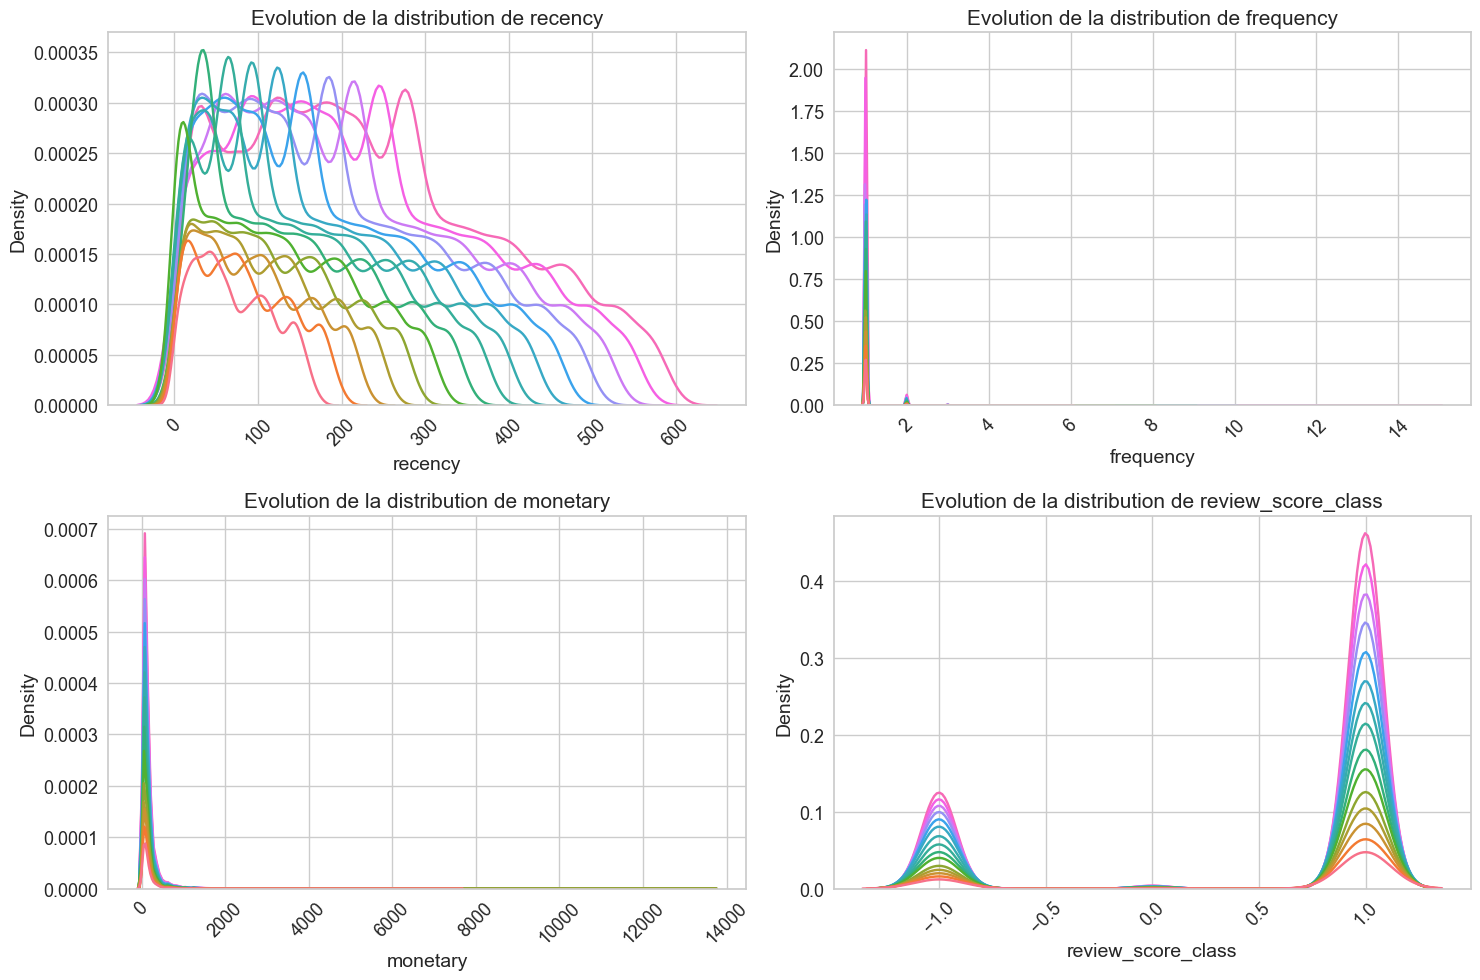

In [24]:
# Evolution de la distribution des variables
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), tight_layout=True)

for i, column in enumerate(df_merged.columns):
    if column != 'date':  # toutes les colonnes sauf dates
        axs = ax[i//2, i%2]
        sns.kdeplot(data=df_merged, x=column, hue='date', ax=axs, legend=False)
        axs.set_title(f'Evolution de la distribution de {column}')
        axs.tick_params(axis='x', rotation=45)

plt.show()

* **Test de Kolmogorov Smirnov**

In [25]:
# Stocker les résultats des tests KS
results_dict = {}

# Boucle pour calculer le test KS pour chaque variable
for i, col in enumerate(dfs_rfms[0].columns):
    results = []
    for j in range(0,len(dfs_rfms)-1):
        ks_statistic, p_value = ks_2samp(dfs_rfms[j].iloc[:,i], dfs_rfms[j+1].iloc[:,i])
        if p_value < 0.05:
            result = 0 # H0  rejetée : les 2 distributions ne sont pas identiques
        else:
            result = 1 # H0  non rejetée : les 2 distributions sont identiques
        results.append(result)

    results_dict[col] = results

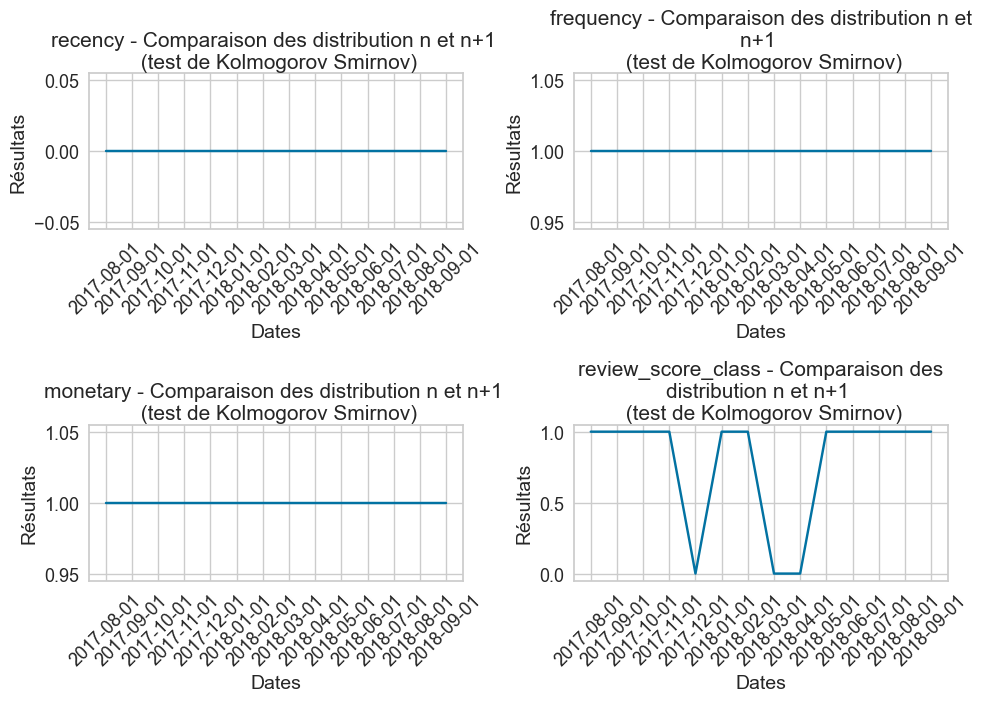

In [26]:
# Afficher les résultats du test KS entre la distribution n et la distribution n+1
dates_to_plot = dates[1:]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 7), tight_layout=True)

axs = axs.flatten()

for i, (col, results) in enumerate(results_dict.items()):
    ax = axs[i]
    ax.plot(dates_to_plot, results)
    ax.set_title(f"{col} - Comparaison des distribution n et n+1 \n (test de Kolmogorov Smirnov)", wrap = True)
    ax.set_xlabel('Dates')
    ax.set_ylabel('Résultats')
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.show()

Le test de Kolmogoriv Smirnov permet de détecter les changements des distributions des variables qui pourraient impacter notre modèle.

# <font color='#0a389f'>Simulation maintenance<a class="anchor" id="partie2"></a></font>

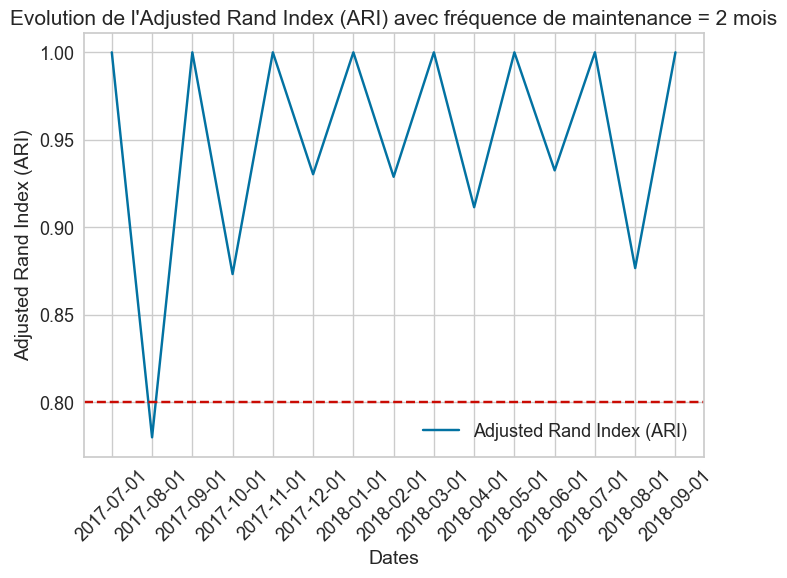

In [27]:
# Simulation d'une maintenance tous les 2 mois
plot_simu(dfs_rfms, dates, k, 2)

# <font color='#0a389f'>Conclusion & Perspectives<a class="anchor" id="conclusion"></a></font>

* La fréquence de maintenance est de 2 mois dans un premier temps. 
* Le nombre de clusters optimal est également un paramètre à surveiller.
* Des gardes-fous sur les changements de distributions des variables pourraient être mis en place comme : 
    * des test statistiques : test de Kolmogorov Smirnov
    * surveillance des bornes de la variable review score si changement de l'échelle de notation 